<a href="https://colab.research.google.com/github/SarahSaeedKhan/DTI/blob/main/ARU_TRY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import cv2
from glob import glob
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook as tqdm
from plotly.offline import iplot
import plotly as py
import plotly.tools as tls
import cufflinks as cf
from IPython.core.display import display, HTML
from pathlib import Path

import tensorflow as tf
from tensorflow.keras.utils import CustomObjectScope
from tqdm import tqdm
import keras
import imgaug.augmenters as iaa
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K

In [ ]:
def conv_block(x, filter_size, size, dropout, batch_norm=False):

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    return conv


def repeat_elem(tensor, rep):

     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)


def res_conv_block(x, filter_size, size, dropout, batch_norm=False):


    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation('relu')(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    #conv = layers.Activation('relu')(conv)    #Activation before addition with shortcut
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    shortcut = layers.Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = layers.BatchNormalization(axis=3)(shortcut)

    res_path = layers.add([shortcut, conv])
    res_path = layers.Activation('relu')(res_path)    #Activation after addition with shortcut (Original residual block)
    return res_path

def gating_signal(input, out_size, batch_norm=False):

    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

# Getting the x signal to the same shape as the gating signal
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

# Getting the gating signal to the same number of filters as the inter_shape
    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn

In [ ]:
def conv_block(x, filter_size, size, dropout, batch_norm=False):

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    return conv


def repeat_elem(tensor, rep):

     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)


def res_conv_block(x, filter_size, size, dropout, batch_norm=False):


    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation('relu')(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    #conv = layers.Activation('relu')(conv)    #Activation before addition with shortcut
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    shortcut = layers.Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = layers.BatchNormalization(axis=3)(shortcut)

    res_path = layers.add([shortcut, conv])
    res_path = layers.Activation('relu')(res_path)    #Activation after addition with shortcut (Original residual block)
    return res_path

def gating_signal(input, out_size, batch_norm=False):

    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

# Getting the x signal to the same shape as the gating signal
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

# Getting the gating signal to the same number of filters as the inter_shape
    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn



def Attention_ResUNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):
    '''
    attention  baed Rsidual UNet

    '''
    # network structure
    FILTER_NUM = 64 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    # input data
    # dimension of the image depth
    # inputs = layers.Input(input_shape, dtype=tf.float32)
    # axis = 3

    inputs = layers.Input((256, 256, 1))
    axis = -1

    # Downsampling layers
    # DownRes 1, double residual convolution + pooling
    conv_128 = res_conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = res_conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = res_conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = res_conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = res_conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=axis)
    up_conv_16 = res_conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=axis)
    up_conv_32 = res_conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=axis)
    up_conv_64 = res_conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=axis)
    up_conv_128 = res_conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers

    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=axis)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model integration
    model = models.Model(inputs, conv_final, name="AttentionResUNet")
    return model

In [ ]:
model = Attention_ResUNet(((256 , 256, 3)), NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True)
model.summary()

Model: "AttentionResUNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                  

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='MSE', optimizer=opt)

In [ ]:
# train_path_miprg=r'/content/drive/MyDrive/data_set/Training_AF2C_data.mat'
# test_path_miprg=r'/content/drive/MyDrive/data_set/Test_AF2C_data.mat'
train_path_miprg=r'/content/drive/MyDrive/MRI-Image-Reconstruction-master/MRI-Image-Reconstruction-master/my1.5TdataAF2.mat'
test_path_miprg=r'/content/drive/MyDrive/MRI-Image-Reconstruction-master/MRI-Image-Reconstruction-master/my1.5TtestAF2.mat'
print("Accessing the training and test data")

Accessing the training and test data


In [ ]:
import numpy as np

# Assume imgs_train is your input image data with shape (N, 256, 256, 1)
train_path_miprg = np.repeat(train_path_miprg, 3, axis=-1)
test_path_miprg = np.repeat(test_path_miprg,3, axis = -1)


# Now imgs_train_rgb has shape (N, 256, 256, 3) and can be used as input to your model.

In [ ]:
import h5py
train_path_miprg = np.array(['/content/drive/MyDrive/MRI-Image-Reconstruction-master/MRI-Image-Reconstruction-master/my1.5TdataAF2.mat'])
data1 = h5py.File(train_path_miprg.item(), 'r')

test_path_miprg = np.array(['/content/drive/MyDrive/MRI-Image-Reconstruction-master/MRI-Image-Reconstruction-master/my1.5TtestAF2.mat'])
data1 = h5py.File(test_path_miprg.item(), 'r')

In [ ]:
train_path_miprg = '/content/drive/MyDrive/MRI-Image-Reconstruction-master/MRI-Image-Reconstruction-master/my1.5TdataAF2.mat'
data1 = h5py.File(train_path_miprg, 'r')

test_path_miprg = '/content/drive/MyDrive/MRI-Image-Reconstruction-master/MRI-Image-Reconstruction-master/my1.5TtestAF2.mat'
data2 = h5py.File(test_path_miprg, 'r')

In [ ]:
import h5py
# Pythonic interface to the HDF5 binary data format
data1=h5py.File(train_path_miprg,'r')
arrays={}
for k, v in data1.items():
    arrays[k] = np.transpose(np.array(np.float32(v)), (0, 2, 1))
    # arrays[k] = np.transpose(np.array(np.float32(v)), (0,3,2,1))
trX =arrays['input']
#trX=np.reshape(trX,(500,256,256,1))
trX=np.reshape(trX,(1407,256,256,1))
#\trX=np.reshape(trX,(1500,256,256,2))
trY =arrays['label']
#trY=np.reshape(trY,(500,256,256,1))
trY=np.reshape(trY,(1407,256,256,1))
#trY=np.reshape(trY,(1500,256,256,2))
imgs_train = trX
imgs_mask_train =trY
#########################################################################
data2=h5py.File(test_path_miprg,'r')
arrays1={}
for k, v in data2.items():
    arrays1[k] = np.transpose(np.array(np.float32(v)), (0, 2, 1))
    # arrays1[k] = np.transpose(np.array(np.float32(v)), (0,3,2,1))
trX1 =arrays1['input']
print(trX1.shape)
#trX1=np.reshape(trX1,(300,256,256,1))
trX1=np.reshape(trX1,(431,256,256,1))
#trX1=np.reshape(trX1,(500,256,256,2))
trY1 =arrays1['label']
#trY1=np.reshape(trY1,(300,256,256,1))
trY1=np.reshape(trY1,(431,256,256,1))
#trY1=np.reshape(trY1,(500,256,256,2))
#######################################################################
test_data = trX1
test_label = trY1
imgs_test=test_data
print("loading data done")


(431, 256, 256)
loading data done


In [ ]:
from keras.callbacks import EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
# Training hyper_parameters
callbacks = [EarlyStopping(patience=100, verbose=1), ReduceLROnPlateau(factor=0.1, patience=10, verbose=1),
             ModelCheckpoint('ResUnet.hdf5', monitor='val_loss',verbose=1, save_best_only=True)]

In [ ]:
# Fit Model
print('Fitting model...')
history=model.fit(imgs_train, imgs_mask_train, batch_size=5, epochs =50,validation_split=0.1, verbose=1, shuffle=True, callbacks=callbacks)
model.save('ResUnet_save.h5')
model.load_weights("ResUnet.hdf5")

Fitting model...
Epoch 1/50
254/254 [==============================] - ETA: 0s - loss: 0.0092
Epoch 1: val_loss improved from inf to 0.02013, saving model to ResUnet.hdf5
254/254 [==============================] - 148s 584ms/step - loss: 0.0092 - val_loss: 0.0201 - lr: 0.0100
Epoch 2/50
254/254 [==============================] - ETA: 0s - loss: 0.0052
Epoch 2: val_loss improved from 0.02013 to 0.00485, saving model to ResUnet.hdf5
254/254 [==============================] - 139s 546ms/step - loss: 0.0052 - val_loss: 0.0049 - lr: 0.0100
Epoch 3/50
254/254 [==============================] - ETA: 0s - loss: 0.0042
Epoch 3: val_loss did not improve from 0.00485
254/254 [==============================] - 137s 539ms/step - loss: 0.0042 - val_loss: 0.0074 - lr: 0.0100
Epoch 4/50
254/254 [==============================] - ETA: 0s - loss: 0.0035
Epoch 4: val_loss improved from 0.00485 to 0.00290, saving model to ResUnet.hdf5
254/254 [==============================] - 139s 547ms/step - loss: 0.00

In [ ]:
print('predict test data')
imgs_mask_test = model.predict(imgs_test,batch_size=5, verbose=1)
np.save('ResUnet.npy', imgs_mask_test)

predict test data
87/87 [==============================] - 14s 152ms/step


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.0/992.0 KB 47.9 MB/s eta 0:00:00


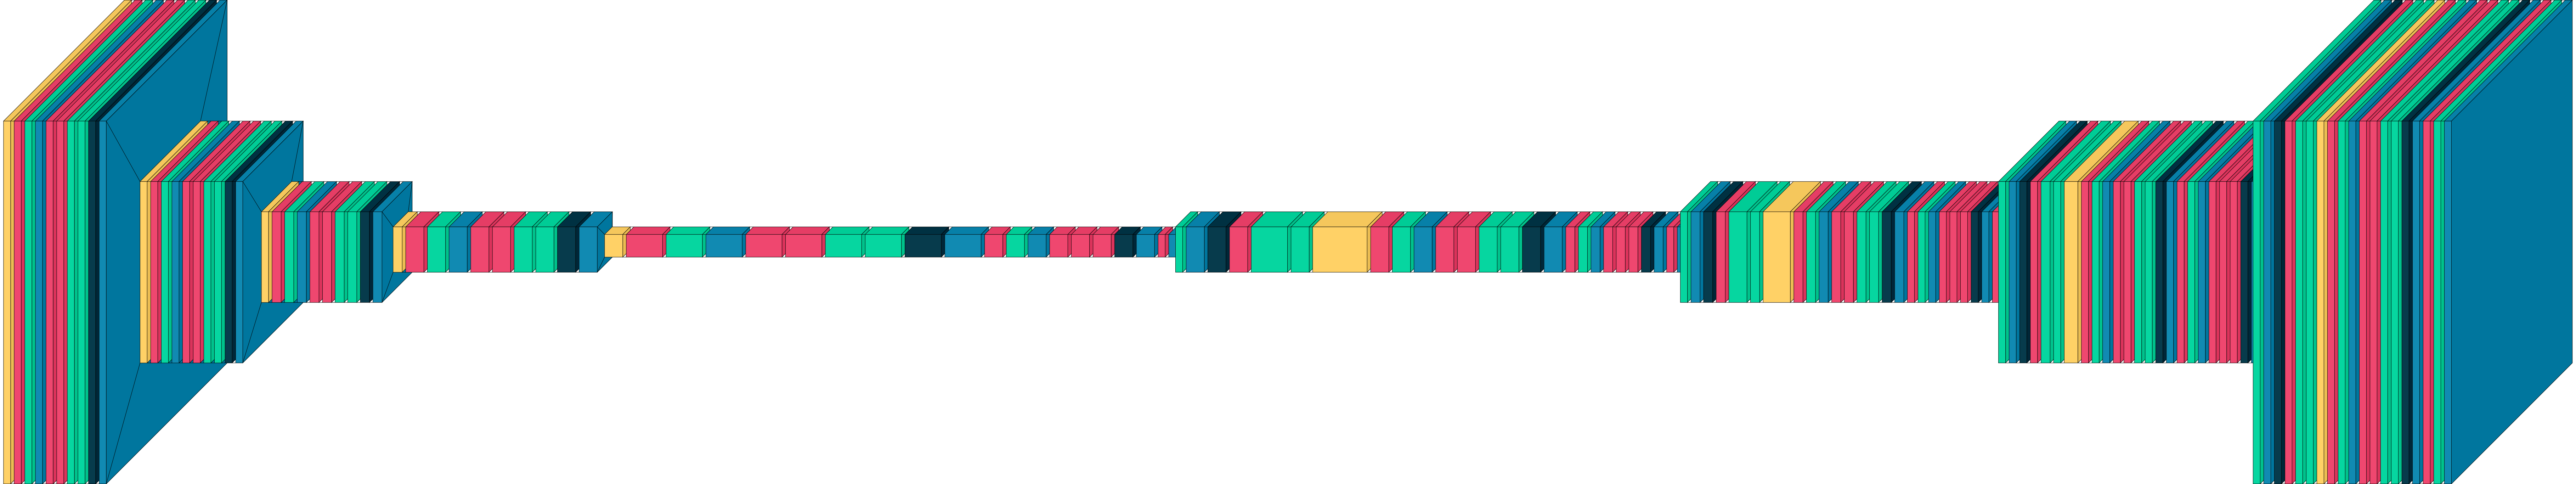

In [ ]:
!pip install visualkeras
#draw diagram of model
import visualkeras
visualkeras.layered_view(model)

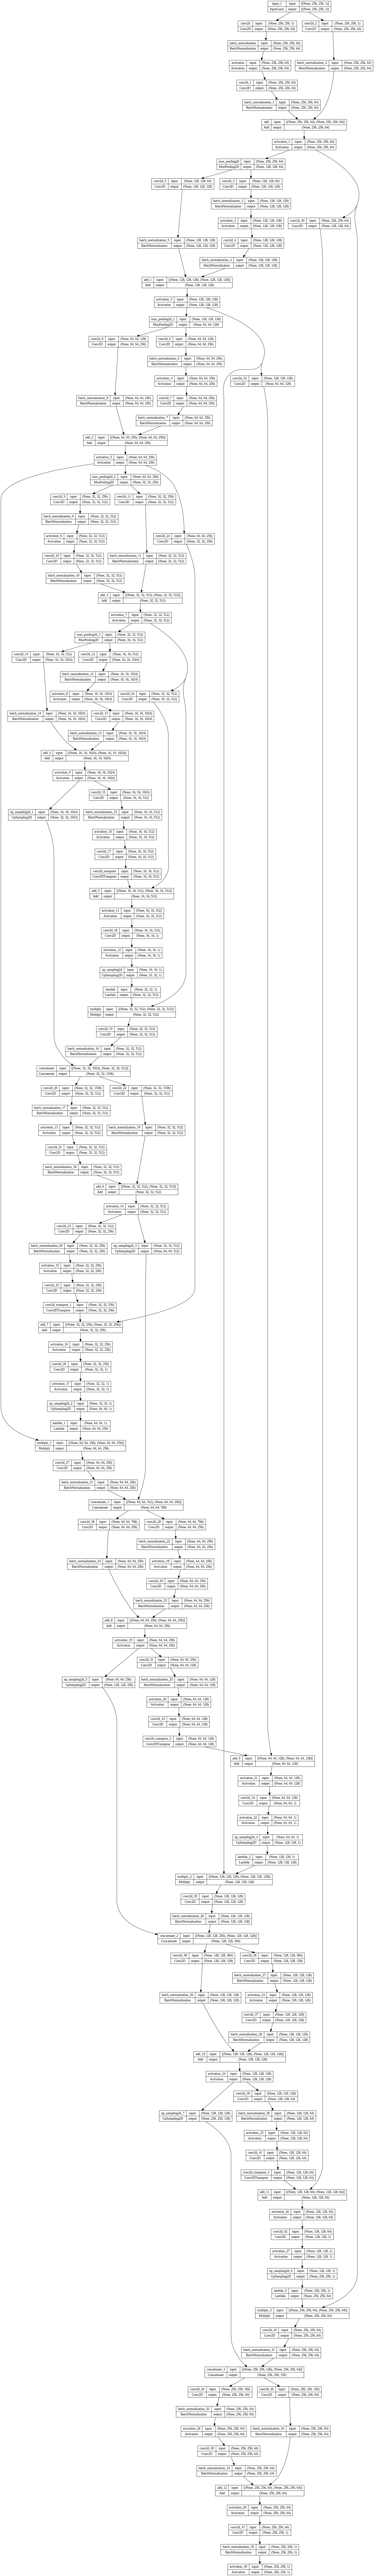

In [ ]:
from keras.utils import plot_model
plot_model(model,show_shapes=True,to_file='xyz.png')

ResUnet-reconstruction
(431, 256, 256, 1)


(<matplotlib.image.AxesImage at 0x7f31b9776ca0>,
 Text(0.5, 1.0, 'ResUnet output'))

<Figure size 432x288 with 0 Axes>

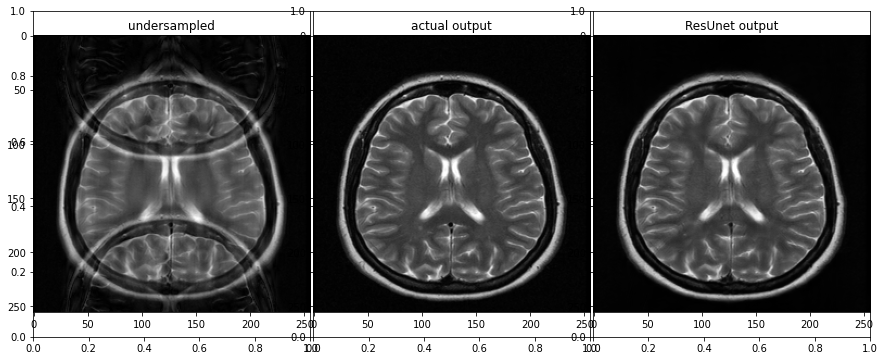

In [ ]:
print('ResUnet-reconstruction')
import matplotlib.pyplot as plt
ResUnet_out={}
ResUnet_out=np.load('ResUnet.npy')
print(ResUnet_out.shape)
image_no=10
plt.figure()
fig, axs = plt.subplots(1,3, figsize=(15,6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.01)
ax=fig.add_subplot(1,3,1)
plt.imshow(test_data[image_no,:,:,0],cmap='gray'),plt.title('Under-Sampled data')
ax=fig.add_subplot(1,3,2)
plt.imshow(test_label[image_no,:,:,0],cmap='gray'),plt.title('Actual Output')
ax=fig.add_subplot(1,3,3)
plt.imshow(ResUnet_out[image_no,:,:,0],cmap='gray'),plt.title('Attention Res-Unet output')